<a href="https://colab.research.google.com/github/TimKo90/crucible-analysis-notebooks/blob/main/insitu-pl-analysis/InSituPL_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import signal
import scipy.integrate as integrate
import copy
import os
import traceback

#from pl_fitting import *

In [27]:
# ================Functions=================================================

def sum_of_Voigts(x, *params):

    if isinstance(x, float):
        x = np.array([x])

    params = np.array(params)
    n = (len(params)-2) // 4

    # divide parameters
    amps   = params[:n]
    mus    = params[n:2*n]
    sigmas = params[2*n:3*n]
    alphas = params[3*n:4*n]

    gaussians  = amps*np.exp(-(x[:, np.newaxis] - mus)**2 / sigmas)
    lorentian  = np.log(2) * (2/np.pi)**0.5 * (amps*sigmas / ((x[:, np.newaxis] - mus)**2 + sigmas*np.log(2)))
    background = params[-2]*x + params[-1]

    return np.dot(gaussians, 1-alphas) + np.dot(lorentian, alphas) + background


def background(x, y0, y1):
    return y0*x + y1


def fWHM_Voigt(x, center, maxValue, params):

    x1 = np.linspace(x[0], center, 5001)
    x2 = np.linspace(center, x[-1], 5001)

    y1 = sum_of_Voigts(x1, *params)
    y2 = sum_of_Voigts(x2, *params)

    root1 = np.interp(maxValue/2,y1,x1)
    root2 = np.interp(maxValue/2,y2[::-1],x2[::-1])

    return root2 - root1


def plFitting(inputDict, df_yCut, df_xCutFit, df_fit, show_every, numGauss, peakLowerTH, peakUpperTH, estPeakWidth, minPeakWidth, maxPeakWidth, name_d, name, PLFits_CenterGuesses, PLFits_Propagate):

    estPositions = PLFits_CenterGuesses

    frames = range(0, len(df_xCutFit))
    frames_to_plot = [i for i in frames if i % show_every == 0]

    yVals = np.copy(df_fit)
    popt = np.array([[np.nan, np.nan, np.nan, np.nan]*int(numGauss) + [np.nan, np.nan]] * np.shape(df_fit)[1])
    peakFWHM = np.array([[np.nan]*int(numGauss)] * np.shape(df_fit)[1])
    peakArea = np.array([[np.nan]*int(numGauss)] * np.shape(df_fit)[1])

    # The next block is to convert the estimated peak positions and ranges into indexes
    idxLowerTH = [0.0]*int(numGauss)
    idxUpperTH = [0.0]*int(numGauss)

    for i in range(0, int(numGauss)):
        idxLowerTH[i] = next(xStart for xStart, valStart in enumerate(df_yCut) if valStart > peakLowerTH[i])
        idxUpperTH[i] = next(xEnd for xEnd, valEnd in enumerate(df_yCut) if valEnd > peakUpperTH[i])

    firstSpectrum = True
    for i in range(0, np.shape(df_fit)[1]):

        # get y values
        yVals[:, i] = np.where(yVals[:, i] == float('inf'), 5, yVals[:, i])

        idx = np.argmax(yVals[0:idxUpperTH[0], i])
        yVals[idx, i] = yVals[idx - 1, i]

        # find peaks
        peaks = signal.find_peaks(yVals[:, i])[0]

        # array initialization
        estAmplitudes = [0.0]*int(numGauss)
        minAmplitudes = [0.0]*int(numGauss)
        maxAmplitudes = [0.0]*int(numGauss)
        estAlphas = [0.5]*int(numGauss)
        minAlphas = [0.0]*int(numGauss)
        maxAlphas = [1.0]*int(numGauss)
        minLinBkg = -1000.0
        estLinBkg = yVals[-1,i] - yVals[0,i]
        maxLinBkg = 1000.0
        minConstBkg = np.min(yVals[:,i])
        estConstBkg = 0.0
        maxConstBkg = np.max(yVals[:,i])


        # no peak, skip
        if len(peaks) == 0:
            print("Time:")
            print(df_xCutFit[i])
            print("No Peak Found")
            continue

        if firstSpectrum:
            firstSpectrum = False
            firstFitIdx = i

            # find initial parameters and bounds for peak amplitudes, having free peaks start more prominent than propagating ones
            for ii in range(0,int(numGauss)):
                if float(PLFits_Propagate[ii]):
                    estAmplitudes[ii] = max(yVals[idxLowerTH[ii]:idxUpperTH[ii], i]) / 5
                    minAmplitudes[ii] = 0
                    maxAmplitudes[ii] = max(yVals[idxLowerTH[ii]:idxUpperTH[ii], i]) / 1.5
                else:
                    estAmplitudes[ii] = max(yVals[idxLowerTH[ii]:idxUpperTH[ii], i])
                    minAmplitudes[ii] = estAmplitudes[ii] / 10
                    maxAmplitudes[ii] = np.inf

            # collecting fit parameters
            estParams = estAmplitudes + estPositions + estPeakWidth + estAlphas + [estLinBkg, estConstBkg]
            lowerBounds = minAmplitudes + peakLowerTH + minPeakWidth + minAlphas + [minLinBkg, minConstBkg]
            upperBounds = maxAmplitudes + peakUpperTH + maxPeakWidth + maxAlphas + [maxLinBkg, maxConstBkg]

        else:
            # update initial parameters and bounds. Propagating peaks have their position and width linked to the first one
            for ii in range(0,int(numGauss)):

                if float(PLFits_Propagate[ii]):
                    estAmplitudes[ii] = max(yVals[idxLowerTH[ii]:idxUpperTH[ii], i]) / 10
                    minAmplitudes[ii] = 0
                    maxAmplitudes[ii] = np.inf
                    estPositions[ii] = popt[firstFitIdx,int(numGauss)+ii]
                    peakLowerTH[ii] = estPositions[ii] * 0.999
                    peakUpperTH[ii] = estPositions[ii] * 1.001
                    estPeakWidth[ii] = popt[firstFitIdx][2*int(numGauss)+ii]
                    minPeakWidth[ii] = estPeakWidth[ii] / 1.01
                    maxPeakWidth[ii] = estPeakWidth[ii] * 1.01

                else:
                    estAmplitudes[ii] = max(yVals[idxLowerTH[ii]:idxUpperTH[ii], i])
                    minAmplitudes[ii] = 0
                    maxAmplitudes[ii] = np.inf

            # collecting fit parameters
            estParams   = estAmplitudes + estPositions + estPeakWidth + estAlphas + [estConstBkg, estLinBkg]
            lowerBounds = minAmplitudes + peakLowerTH + minPeakWidth + minAlphas + [minLinBkg, minConstBkg]
            upperBounds = maxAmplitudes + peakUpperTH + maxPeakWidth + maxAlphas + [maxLinBkg, maxConstBkg]

        # try fitting
        try:
            popt[i], pcov = curve_fit(sum_of_Voigts,
                                   df_yCut,
                                   yVals[:, i],
                                   p0     = estParams,
                                   bounds = (lowerBounds, upperBounds)
                                   )


        except Exception:
            print("Time:")
            print(df_xCutFit[i])
            traceback.print_exc()
            pass

        for ii in range(0,int(numGauss)):
            parameters = [popt[i,ii], popt[i,int(numGauss)+ii], popt[i,2*int(numGauss)+ii], popt[i,3*int(numGauss)+ii], 0, 0]
            peakFWHM[i,ii] = fWHM_Voigt(df_yCut, popt[i,int(numGauss)+ii], sum_of_Voigts(popt[i,int(numGauss)+ii], *parameters), parameters)
            peakArea[i,ii] = integrate.quad(lambda x: sum_of_Voigts(x, *parameters), -np.inf,np.inf)[0]

        # plotting fit results for pre-selected frames
        if i in frames_to_plot:

            plt.figure(figsize=(6, 5))
            plt.plot(df_yCut, yVals[:, i], 'o', label='data')
            plt.plot(df_yCut, sum_of_Voigts(df_yCut, *popt[i,:]), 'r-', label='fit')

            for ii in range(0, int(numGauss)):
                plt.plot(df_yCut, sum_of_Voigts(df_yCut, *[popt[i,ii], popt[i,int(numGauss)+ii], popt[i,2*int(numGauss)+ii], popt[i,3*int(numGauss)+ii], 0, 0]), '--', label='Peak ' + str(ii+1))

            plt.plot(df_yCut, background(df_yCut, *[popt[i,-2], popt[i,-1]]), 'k--', label='Background')
            plt.legend()
            plt.xlabel('Energy (eV)')
            plt.ylabel('Intensity (a.u.)')
            plt.title('Time: ' + str(df_xCutFit[i]))
            plt.savefig(os.path.join(name + '/fits/', str(name_d) + '_PL-fit_' + str(int(df_xCutFit[i])) + '_s.png'), format = 'png')
            plt.show(block=False)
            plt.pause(1)

            if inputDict['logplots']:
                plt.figure(figsize=(6, 5))
                plt.plot(df_yCut, np.log(yVals[:, i]), 'o', label='data')
                plt.plot(df_yCut, np.log(sum_of_Voigts(df_yCut, *popt[i,:])), 'r-', label='fit')
                plt.legend()
                plt.xlabel('Energy (eV)')
                plt.ylabel('Log-Intensity (a.u.)')
                plt.title('Time: ' + str(df_xCutFit[i]))
                plt.savefig(os.path.join(name + '/fits/', str(name_d) + '_PL-fit_Log_' + str(int(df_xCutFit[i])) + '_s.png'), format = 'png')
                plt.show(block=False)
                plt.pause(1)

    # Plotting the time-evolution of the peak-positions and intensities
    for i in range(0, int(numGauss)):
        fig, ax1 = plt.subplots(figsize=(6, 5))
        plot1, = ax1.plot(df_xCutFit, popt[:,int(numGauss)+i], label = 'Peak Position')
        ax2 = ax1.twinx()
        plot2, = ax2.plot(df_xCutFit, popt[:,i], 'g', label = 'Peak Intensity')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel(r'PL Position (eV)')
        ax2.set_ylabel(r'PL Intensity (a.u.)')
        # Create your ticker object with M ticks
        yticks = ticker.MaxNLocator(5)
        ax1.yaxis.set_major_locator(yticks)
        fig.suptitle('Fit Results Peak ' + str(i+1) + ' ' + name_d, fontsize=14)
        fig.legend()

    # collecting the fit results in a dataframe
    dfPeaks = pd.DataFrame()
    dfPeaks['Fit-Time_' + name_d] = df_xCutFit
    for i in range(0,int(numGauss)):
        colPos = 'Peak' + str(i+1) + 'Pos_' + name_d
        colArea = 'Peak' + str(i+1) + 'Area_' + name_d
        colFWHM = 'Peak' + str(i+1) + 'FWHM_' + name_d
        colAlphas = 'Peak' + str(i+1) + 'Alpha_' + name_d
        data = np.array([peakArea[:,i], popt[:,int(numGauss)+i], peakFWHM[:,i], popt[:,3*int(numGauss)+i]])
        dfTemp = pd.DataFrame(
            data.T,
            columns=[colArea, colPos, colFWHM, colAlphas])
        dfPeaks = pd.concat([dfPeaks, dfTemp], axis=1)
    dfPeaks = dfPeaks.fillna('nan')

    return dfPeaks


def plFits(inputDict, energyPL, timePL, intPL, sampleName, savePath, numGauss,
           PLFits_CenterGuesses = ["list of length num gauss containing the user's Initial guess for Peak position (in eV) as a float"],
           PLFits_CenterFixed = ["list of True/False will the center be fixed"],
           PLFits_Propagate=['list of True/False for propagate']):

    # Fit-parameters: Set the lower and upper limits as well as the estimated position of each peak (in nm).
    # From left to right, update as many integers as needed but keep the length of arrays at 5; extra values are ignored.
    peakLowerTH = [0.0]*int(numGauss)
    peakUpperTH = [0.0]*int(numGauss)
    estPeakWidth = [0.0] *int(numGauss)
    minPeakWidth = [0.0] *int(numGauss)
    maxPeakWidth = [0.0] *int(numGauss)


    for i in range(0, int(numGauss)):

        if PLFits_CenterFixed[i] is True:
            peakLowerTH[i] = float(PLFits_CenterGuesses[i]) - 0.005
            peakUpperTH[i] = float(PLFits_CenterGuesses[i]) + 0.005
            estPeakWidth[i] = (0.1/1.665)**2
            minPeakWidth[i] = (0.0/1.665)**2
            maxPeakWidth[i] = (0.5/1.665)**2
        else:
            peakLowerTH[i] = energyPL[0]
            peakUpperTH[i] = energyPL[-2]
            estPeakWidth[i] = (0.1/1.665)**2
            minPeakWidth[i] = (0/1.665)**2
            maxPeakWidth[i] = (1/1.665)**2

    show_every = int(len(timePL)/10)     # shows every tenth frame with fit

    df_fitResults = plFitting(inputDict, energyPL, timePL, intPL, show_every, numGauss, peakLowerTH, peakUpperTH, estPeakWidth, minPeakWidth, maxPeakWidth, sampleName, savePath, PLFits_CenterGuesses, PLFits_Propagate)

    return df_fitResults



In [3]:
# mount your google drives
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
inputDict = {
               'smoothing' : False,   # Smoothing of the data to reduce noise
               'sFactor' : 3,         # Parameter for smoothing with a SavGol-Filter
               'energyScale' : True,
               'bkgCorr' : False,     # Enable linear background removal. If True, the program will ask for two ranges for the removal. I recommend setting one of them at higher and the other at lower energy compared to the peaks of interest.
               'bkgCorrPoly' : 1,     # This parameter determines the order of the polynomial fit used for background correction (0=const, 1=linear, etc.)
               'logplots': 0,
               }

### Load and View Sample

In [7]:
dataset_options = glob.glob("/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/*/*.zip")

print("Datasets found at the path above are: ")
for ds in dataset_options:
  print(os.path.basename(ds).replace(".zip", ""))

Datasets found at the path above are: 
Keonwoo_AEM-Revision
Keonwoo_FAPI-SAMs


In [8]:
#dataset_id = ""

sample_options = glob.glob("/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/*/*_dataframe.csv")
print("Datasets found at the path above are: ")
for s in sample_options:
  print(s)

Datasets found at the path above are: 
/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgr0npq7nvvq0008tmbk9fgkw/FAPII_dataframe.csv
/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgr0npq7nvvq0008tmbk9fgkw/FAPI_MACl_dummy_dataframe.csv
/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgr0npq7nvvq0008tmbk9fgkw/FAPI_MACl_dataframe.csv
/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgr0npq7nvvq0008tmbk9fgkw/FAPI_Dummy_dataframe.csv
/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgr0npq7nvvq0008tmbk9fgkw/FAPI2_dataframe.csv
/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgspmvyrnz6n000gs0z5mfhx8/MeO-2pacz-0 percent-re-20221214_dataframe.csv
/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgspmvyrnz6n000gs0z5mfhx8/2pacz-2-percent-20221214_dataframe.csv
/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgspmvyrnz6n000gs0z5mfhx8/2pacz-1-percent-20221214_dataframe.csv
/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgspmv

In [9]:
sample_path = "/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgspmvyrnz6n000gs0z5mfhx8/MeO-2pacz-0 percent-re-20221214_dataframe.csv"
sample_name = "FAPII"

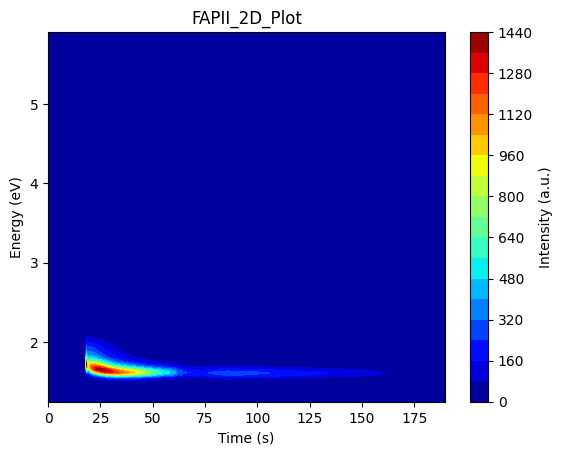

In [10]:
df = pd.read_csv(f"{sample_path}", index_col = "wl")

num_sort = [str(x) for x in sorted([float(x) for x in df.columns])]
df = df.reindex(num_sort, axis=1)

# load and convert to arrays
df_y = np.array(df.index)
df_x = np.array([float(x) for x in df.columns])

df = df.to_numpy()
df = np.where(df <= 0, 0, df)

# transition to energy scale of the y axis
if inputDict['energyScale'] == True:
    df_y = [1240 / i for i in df_y]

    # Jacobian transformation for all measured PL values (basically dividing by E^2)
    for i in range(np.shape(df)[1]):
        df[:, i] = df[:, i] / df_y / df_y

    # Mirroring dataframes to prevent sorting issues
    df_y = np.flip(df_y)
    df = np.flip(df, axis=0)

    yAxisLabel = 'Energy (eV)'

else:
    yAxisLabel = 'Wavelength (nm)'

# Simple plot of the data
plot_name = f"{sample_name}_2D_Plot.png"

plt.figure(1)
plt.contourf(df_x, df_y, df, 20, cmap=plt.cm.jet)

# Make a colorbar for the ContourSet
cbar = plt.colorbar()
cbar.ax.set_ylabel('Intensity (a.u.)')

# adding labels
plt.xlabel('Time (s)')
plt.ylabel(yAxisLabel)
plt.title(plot_name.strip(".png"))

plt.savefig(plot_name)

### (Optional) Run Background Subtraction

In [ ]:
# define the following in eV or nm ( you can pick a range on either side of the peak )

# background correction range 1 start/end value
y_bkgStart1 =0
y_bkgEnd1 = 1

# background correction range 2 start/end value
y_bkgStart2 = 3
y_bkgEnd2 = 5

In [ ]:
# run bkgd subtraction
l_bkgStart1 = next(xStart for xStart, valStart in enumerate(df_y) if valStart > y_bkgStart1)
l_bkgEnd1 = next(xEnd for xEnd, valEnd in enumerate(df_y) if valEnd > y_bkgEnd1) - 1
l_bkgStart2 = next(xStart for xStart, valStart in enumerate(df_y) if valStart > y_bkgStart2)
l_bkgEnd2 = next(xEnd for xEnd, valEnd in enumerate(df_y) if valEnd > y_bkgEnd2) - 1

for i in range(0, len(df_x)):
    xVals = np.concatenate([df_y[l_bkgStart1:l_bkgEnd1], df_y[l_bkgStart2:l_bkgEnd2]])
    yVals = np.concatenate([df[l_bkgStart1:l_bkgEnd1, i], df[l_bkgStart2:l_bkgEnd2, i]])
    coefs = np.polyfit(xVals, yVals, 1)  # The last parameter determines the order of the polynomial fit (0=const)
    poly1d_fn = np.poly1d(coefs)
    df[:, i] = df[:, i] - poly1d_fn(df_y[:])

### Plot Region of Interest

In [12]:
# define the following
startTime = 0.0

# Wavelength/Energy region to be plotted
y_start = 1
y_end = 2.5

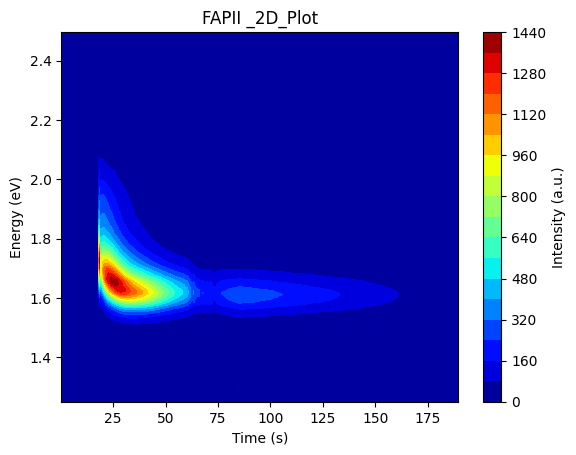

In [13]:
# run
startTimeIdx = next(tStart for tStart, valStart in enumerate(df_x) if valStart > startTime)
l_start = next(xStart for xStart, valStart in enumerate(df_y) if valStart > y_start)
l_end = next(xEnd for xEnd, valEnd in enumerate(df_y) if valEnd > y_end) - 1

# shortening the wavelength/energy region to interesting region
df_cut = df[l_start:l_end+1, startTimeIdx:]
df_cutFit = df[:, startTimeIdx:]

# same shortening for the Y-axis and X-axis arrays
df_yCut = df_y[l_start:l_end+1]
df_xCut = df_x[startTimeIdx:]
df_xCut = df_xCut - startTime

if inputDict['smoothing']:
    df_cut = savgol_filter(df_cut, inputDict['sFactor'], 0)
    df_cutFit = savgol_filter(df_cutFit, inputDict['sFactor'], 0)

# Show the resulting data
plt.figure(3)
plt.contourf(df_xCut, df_yCut, df_cut, 20, cmap=plt.cm.jet)
# Make a colorbar for the ContourSet
cbar = plt.colorbar()
cbar.ax.set_ylabel('Intensity (a.u.)')
# adding labels
plt.xlabel('Time (s)')
plt.ylabel(yAxisLabel)
plt.title(str(sample_name) + ' _2D_Plot')
plt.pause(1)

### Bin the data
sum a certain number (bin_size) of spectra to improve the fitting accuracy at the cost of time resolution

In [14]:
# define the number of spectra to sum per bin
# set to 0 if you don't want to bin
bin_size = 0

In [15]:
if bin_size > 0:
    df_cutBin = copy.deepcopy(df_cutFit)
    df_cutBin = df_cutFit[:, 0:int(df_xCut.shape[0]/bin_size)]
    for i in range(0, df_cutBin.shape[1]):
        df_cutBin[:,i] = np.sum(df_cutFit[:, bin_size*i:bin_size*i+bin_size], axis=1)
    df_fit = df_cutBin
    df_xCutFit = df_xCut[::inputDict['binning']][0:df_cutBin.shape[1]]
    df_yCut = df_y
else:
    df_fit = df_cut
    df_xCutFit = df_xCut

### Fit the Data

In [16]:
# set the following parameters
numGauss = 2
PLFits_CenterGuesses = [1.65, 1.7] # for each gaussian you think exists, put a float of the eV/wl at which you think there is a peak
PLFits_CenterFixed = [False, False] # for each gaussian, put a value True/False if you think the center is fixed
PLFits_Propagate = [False, False] # for each gaussian, put a value True/False for propagate

[Errno 17] File exists: '/content/drive/Shareddrives/MFUSER_timkodalle/Datasets/0sgspmvyrnz6n000gs0z5mfhx8/fits'


<ipython-input-27-4143855e35bb>:159: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  peakFWHM[i,ii] = fWHM_Voigt(df_yCut, popt[i,int(numGauss)+ii], sum_of_Voigts(popt[i,int(numGauss)+ii], *parameters), parameters)


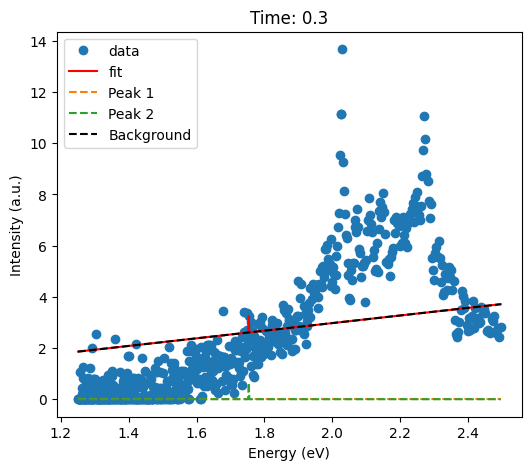

Time:
0.6


Traceback (most recent call last):
  File "<ipython-input-27-4143855e35bb>", line 143, in plFitting
    popt[i], pcov = curve_fit(sum_of_Voigts,
  File "/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py", line 978, in curve_fit
    raise RuntimeError("Optimal parameters not found: " + res.message)
RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.
<ipython-input-27-4143855e35bb>:160: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  peakArea[i,ii] = integrate.quad(lambda x: sum_of_Voigts(x, *parameters), -np.inf,np.inf)[0]


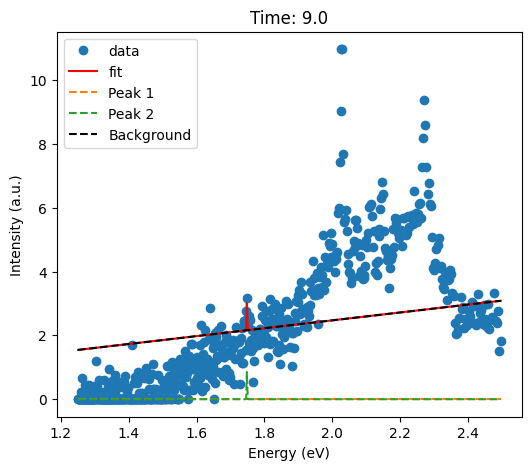

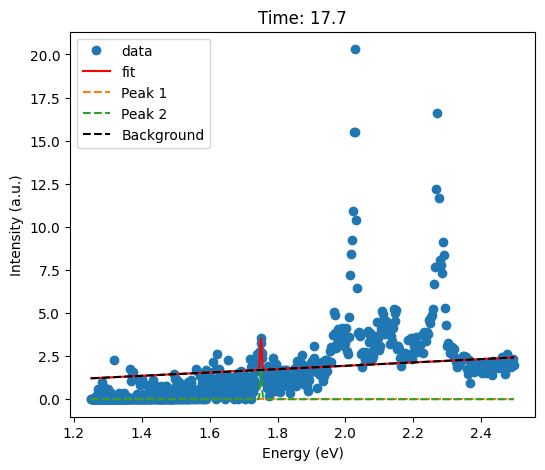

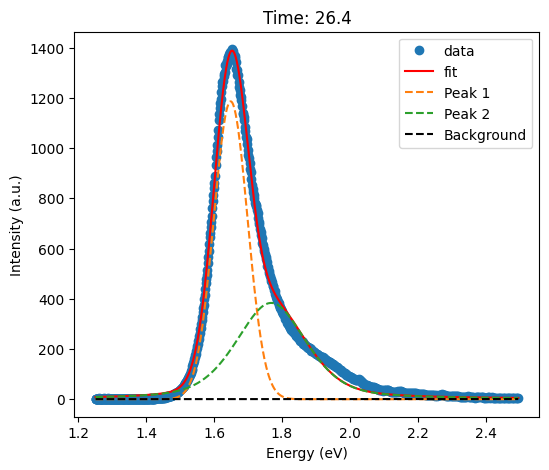

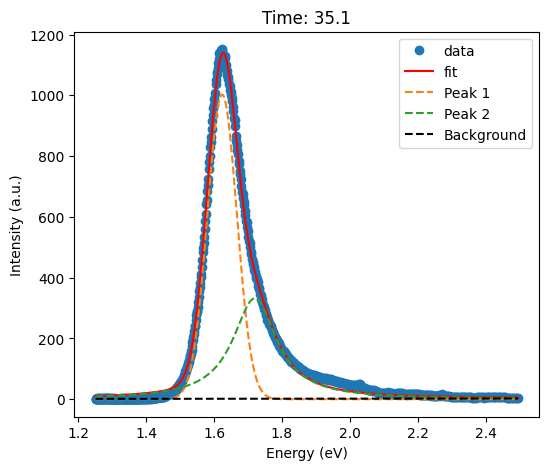

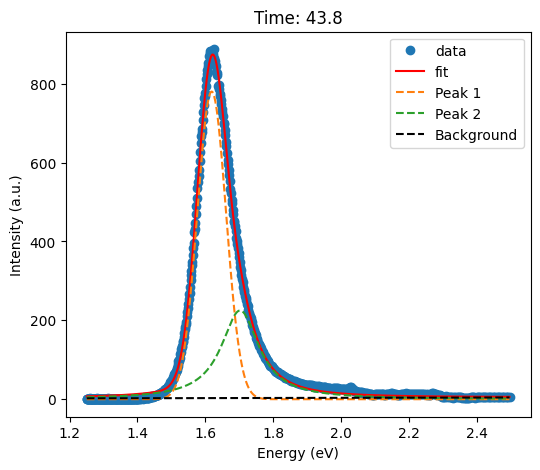

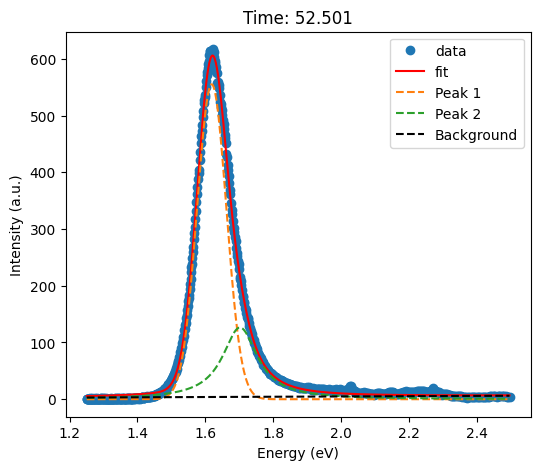

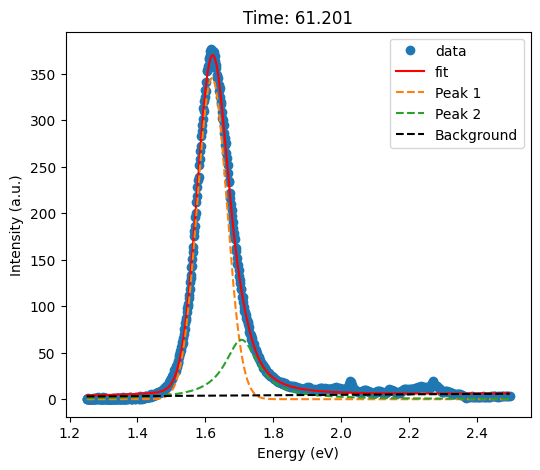

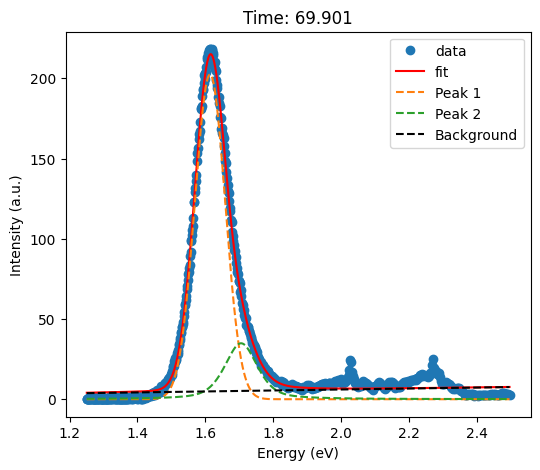

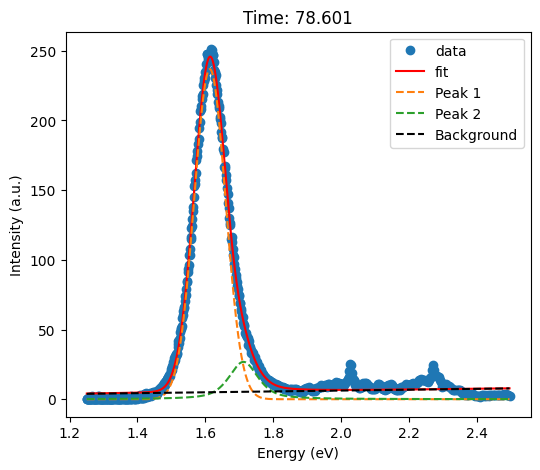

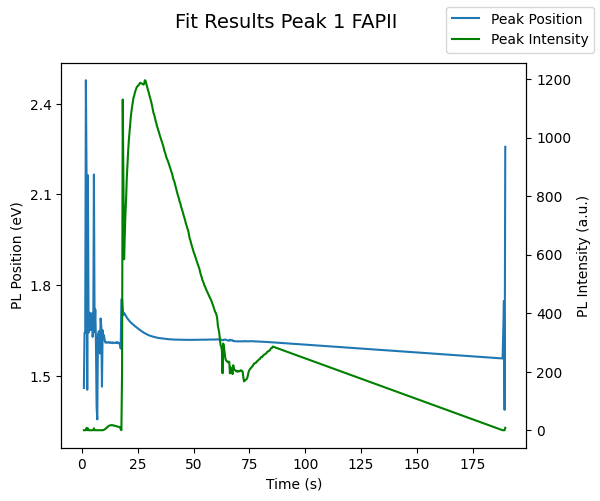

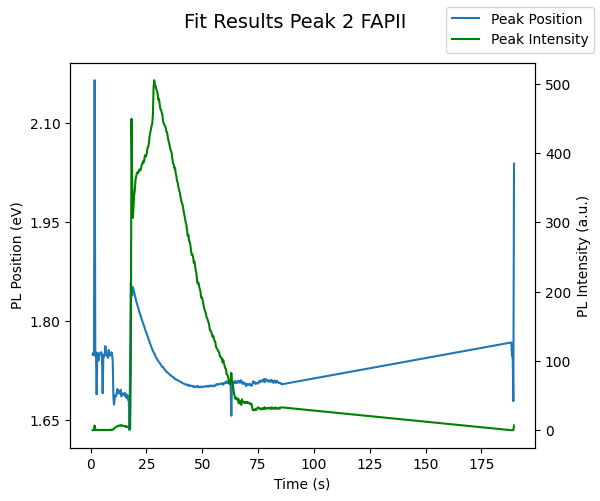

In [28]:
# you can rerun this to restart the fit
result_path = os.path.join(os.path.dirname(sample_path), "fits")
try:
  os.mkdir(result_path)
except Exception as e:
  print(e)
df_fitResults = plFits(inputDict, df_yCut, df_xCutFit, df_fit, sample_name, os.path.dirname(sample_path), numGauss, PLFits_CenterGuesses, PLFits_CenterFixed, PLFits_Propagate)

In [ ]:
### Save the Results
np.savetxt(f'{result_path}/{sample_name}_2D.csv', df_fit, delimiter=",")
np.savetxt(f'{result_path}/{sample_name}_time.csv', df_xCutFit, delimiter=",", header='Time_' + sample_name, comments='')
np.savetxt(f'{result_path}/{sample_name}_energy.csv', df_yCut, delimiter=",", header='Energy_' + sample_name, comments='')
df_fitResults.to_csv(f"{result_path}/{sample_name}_PL_FitResults.csv", index=False)